## Imports

In [43]:
from typing import List
from pathlib import Path
import bs4
from tqdm import tqdm
import pandas as pd
import os

## Notes

- it would be nice if the TextEnt pipeline could automatically add XML IDs to elements of interest, especially entities
- the imprint of each book contains place/person names, which we should filter out, as it affects the analysis (it tends to mention lots of people and places that do not capture the drama's setting)
- `bpt6k852871n.tar.gz.tei_segmented_ner.xml` bad entity recognition/normalization: example of Monomotapa 
- **Q**: is there a correlation between the length of a document and the number of entity mentions it contains?
- NER data quality: 
    - there is quite a lot of very short entities (`length <= 2`) occurring (mostly?) in very short contexts
    - similarly, a number of very long entities (`length > 30`) seem to occur in the book's "dedica" section

## Functions

In [2]:
def xpath_soup(element):
    # function copied from https://gist.github.com/ergoithz/6cf043e3fdedd1b94fcf
    # type: (typing.Union[bs4.element.Tag, bs4.element.NavigableString]) -> str
    """
    Generate xpath from BeautifulSoup4 element.
    :param element: BeautifulSoup4 element.
    :type element: bs4.element.Tag or bs4.element.NavigableString
    :return: xpath as string
    :rtype: str
    Usage
    -----
    >>> import bs4
    >>> html = (
    ...     '<html><head><title>title</title></head>'
    ...     '<body><p>p <i>1</i></p><p>p <i>2</i></p></body></html>'
    ...     )
    >>> soup = bs4.BeautifulSoup(html, 'html.parser')
    >>> xpath_soup(soup.html.body.p.i)
    '/html/body/p[1]/i'
    >>> import bs4
    >>> xml = (
    ...     '<?xml version="1.0" encoding="UTF-8"?>'
    ...     '<doc xmlns:ns1="http://localhost/ns1"'
    ...     '     xmlns:ns2="http://localhost/ns2">'
    ...     '<ns1:elm/><ns2:elm/><ns2:elm/></doc>'
    ...     )
    >>> soup = bs4.BeautifulSoup(xml, 'lxml-xml')
    >>> xpath_soup(soup.doc.find('ns2:elm').next_sibling)
    '/doc/ns2:elm[2]'
    """
    components = []
    target = element if element.name else element.parent
    for node in (target, *target.parents)[-2::-1]:  # type: bs4.element.Tag
        tag = '%s:%s' % (node.prefix, node.name) if node.prefix else node.name
        siblings = node.parent.find_all(tag, recursive=False)
        components.append(tag if len(siblings) == 1 else '%s[%d]' % (tag, next(
            index
            for index, sibling in enumerate(siblings, 1)
            if sibling is node
            )))
    return '/%s' % '/'.join(components)

In [3]:
def extract_text_from_tei(tei_file_path: Path) -> str:
    """
    Extracts text content from a TEI (Text Encoding Initiative) XML file.
    Only `<reg>` elements are kept, all other elements are discarded (<reg> contain a normalised version of each textual element).

    Args:
        tei_file_path (Path): The file path to the TEI XML file.

    Returns:
        str: The extracted text content from the TEI XML file.
    """
    with open(tei_file_path, 'r', encoding='utf-8') as file:
        soup = bs4.BeautifulSoup(file, 'xml')
        reg_elements = soup.find_all('reg')
        text = " ".join([el.text for el in reg_elements])
    return text

In [4]:
from dataclasses import dataclass

@dataclass
class EntityMention:
    document_id: str
    segment_text: str
    entity_type: str
    mention: str
    mention_id: str
    

In [7]:
def extract_entities_from_tei(tei_file_path : Path) -> List[EntityMention]:
    # open tei file with beautiful soup
    # iterate over all `<reg>` elements
    # if a `<reg>` element contains a `persName` or `placeName` element, extract entity information
    # add `<reg>` to a dictionary of segments (xapth of the element is the key in dict)
    # add entity information to a list of entity mentions
    # add segment_id + entity_id to a list of segment_entity_mentions
    with open(tei_file_path, 'r', encoding='utf-8') as file:
        soup = bs4.BeautifulSoup(file, 'xml')
    
    output = []

    reg_elements = soup.find_all('reg')
    for el in reg_elements:
        mentions = el.find_all('persName') + el.find_all('placeName')
        for mention in mentions:
            entity_type = mention.name
            mention_text = mention.text
            mention_id = xpath_soup(mention)
            entity_mention = EntityMention(tei_file_path.stem, el.text, entity_type, mention_text, mention_id)
            output.append(entity_mention)
    return output

## Down to business

In [10]:
corpus_basedir = Path("../TheatreLFSV2-downloaded/")

In [11]:
tei_files_paths = list(Path(corpus_basedir / 'NER').iterdir())

In [8]:
#tei_files_paths[:10]

In [59]:
!cat {tei_files_paths[0]}

<?xml version='1.0' encoding='UTF-8'?>
<TEI xmlns="http://www.tei-c.org/ns/1.0">
  <teiHeader>
    <fileDesc>
      <titleStmt>
        <title>Adonis , tragédie françoyse de Gabriel Le Breton,... seigneur de La Fon. Reveu &amp; corrigé de nouveau par le mesme autheur</title>
        <author>Le Breton, Guillaume</author>
        <respStmt>
          <resp>Acquisition &amp; transformation by</resp>
          <persName>
            <forename>Thibault</forename>
            <surname>Clérice</surname>
            <idno type="orcid">0000-0003-1852-9204</idno>
          </persName>
          <persName>
            <forename>Simon</forename>
            <surname>Gabay</surname>
            <idno type="orcid">0000-0001-9094-4475</idno>
          </persName>
        </respStmt>
      </titleStmt>
      <extent>
        <measure unit="images" n=""/>
      </extent>
      <publicationStmt>
        <publisher>COLaF</publisher>
        <authority>Inria</authority>
        <availability status="restr

### Stats about document length

In particular  if we plan to use LLMs for further processing, it is important to know more about the document length distribution, as LLMs have a context window of limited size.

In [33]:
docs = []
for tei_files_path in tqdm(tei_files_paths, desc="Extracting plain text from TEI files"):
    text = extract_text_from_tei(tei_files_path)
    doc = {
        "text": text,
        "path": tei_files_path,
        "word_count": len(text.split()),
        "ark_id": tei_files_path.name.split('.')[0]
    }
    docs.append(doc)
docs_df = pd.DataFrame(docs).set_index("ark_id")

Extracting plain text from TEI files: 100%|██████████| 594/594 [02:41<00:00,  3.67it/s]


ArrowInvalid: ("Could not convert PosixPath('../TheatreLFSV2-downloaded/NER/bpt6k5628858f.tar.gz.tei_segmented_ner.xml') with type PosixPath: did not recognize Python value type when inferring an Arrow data type", 'Conversion failed for column path with type object')

In [44]:
for doc in tqdm(docs, desc="Serializing plain text documents to disk"):
    path = os.path.join("data/corpus_normalized", doc['ark_id'] + ".txt")
    with open(path, "w") as f:
        f.write(doc['text'])

Serializing plain text documents to disk: 100%|██████████| 594/594 [00:00<00:00, 1539.99it/s]


In [41]:
docs_df.path = docs_df.path.to_string() # there was a problem with Parquet and serialization of Path objects
docs_df.to_parquet("data/dataframes/documents.parquet") # serialize for later use

In [11]:
docs_df.sample(5)

,text,path,word_count
ark_id,,,
bpt6k10902166,"LA TRAGÉDIE DE PRIAM,ROY. DE TROYE. \nMadame d...",TheatreLFSV2-downloaded/NER/bpt6k10902166.tar....,10376
bpt6k1090147d,"De Votre GRANDEUR, Le très humone, crémouerhau...",TheatreLFSV2-downloaded/NER/bpt6k1090147d.tar....,14629
bpt6k1512308m,"ACTEURS DU PROLOGUE. DAMON, Fils. CRISPIN, Val...",TheatreLFSV2-downloaded/NER/bpt6k1512308m.tar....,3755
bpt6k1090290r,"TRAGICOMEDIE PASTORALLLE Les amours d'Astre , ...",TheatreLFSV2-downloaded/NER/bpt6k1090290r.tar....,27956
bpt6k1092835,"TLÉDAME DEXXEXES* ADAME, Si mon esprit était c...",TheatreLFSV2-downloaded/NER/bpt6k1092835.tar.g...,18181


In [12]:
docs_df.describe()

,word_count
count,594.000000
mean,17030.365320
std,17039.788704
min,1600.000000
25%,9231.750000
50%,14802.500000
75%,17664.750000
max,155905.000000


<Axes: ylabel='Frequency'>

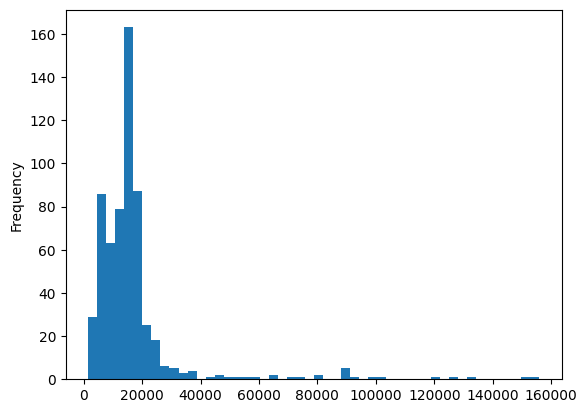

In [13]:
docs_df.word_count.plot.hist(bins=50)

<Axes: >

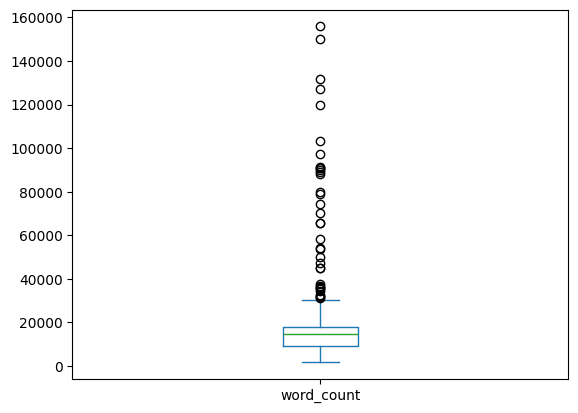

In [14]:
docs_df.word_count.plot.box()

In [20]:
# 95% of the documents in the corpus have up to this number of words:
docs_df.word_count.quantile(0.95)

35376.60000000001

In [22]:
# the remaining 5% of the documents in the corpus (with more than ~35k words)
# they are clearly outliers
docs_df[docs_df.word_count > docs_df.word_count.quantile(0.95)].shape

(30, 3)

In [23]:
# worth taking a look at this one:
docs_df[docs_df.word_count == docs_df.describe()['word_count']['max']]

,text,path,word_count
ark_id,,,
bpt6k1090269b,"À TRÈS HAUT, ET TRÈS puissant FRANOISCOMTE DE ...",TheatreLFSV2-downloaded/NER/bpt6k1090269b.tar....,155905


In [24]:
# total number of documents in the corpus
len(docs_df)

594

In [25]:
#docs_df[docs_df.word_count < 5000]

### Stats about entity mentions

#### Create and save an entity mention dataframe

In [15]:
all_mentions = []
for tei_files_path in tqdm(tei_files_paths, desc="Extracting entity mentions from TEI files"):
    mentions = extract_entities_from_tei(tei_files_path)
    all_mentions += mentions

Extracting entity mentions from TEI files: 100%|██████████| 594/594 [04:14<00:00,  2.33it/s]


In [16]:
# Total number of entity mentions in the corpus
len(all_mentions)

292201

In [17]:
df = pd.DataFrame(all_mentions)
df['mention_length'] = df.mention.apply(len) # mention length to diagnose abnormally long mentions
df['mention_normalised'] = df.mention.apply(lambda x: x.lower()) # lowercasing the mentions for easier analysis

In [22]:
df.set_index(['document_id', 'mention_id'], inplace=True)

In [26]:
df.reset_index(inplace=True)

In [27]:
df.sample(10)

,document_id,mention_id,segment_text,entity_type,mention,mention_length,mention_normalised
67661,bpt6k1280467d.tar.gz.tei_segmented_ner,/TEI/text/body/sp[80]/ab/seg[1]/reg/placeName[1],"SGANARELLE Champagne, ChampagneChampagne vite,...",placeName,Champagne,9,champagne
219276,bpt6k6255600p.tar.gz.tei_segmented_ner,/TEI/text/body/sp[241]/ab/seg[1]/reg/persName,\nDORITE\n,persName,DORITE,6,dorite
66504,bpt6k1280440r.tar.gz.tei_segmented_ner,/TEI/text/body/sp[256]/ab/seg[2]/reg/persName,"Ma Nièce, elle n'a rien que de très -agréable,...",persName,Eraste,6,eraste
186999,bpt6k856804g.tar.gz.tei_segmented_ner,/TEI/text/body/p[129]/seg[17]/reg/persName,\nPHILID\n,persName,PHILID,6,philid
571,btv1b8610790n.tar.gz.tei_segmented_ner,/TEI/text/body/sp[374]/ab/seg[1]/reg/persName,\nPHILAMINTE\n,persName,PHILAMINTE,10,philaminte
240159,bpt6k5767243z.tar.gz.tei_segmented_ner,/TEI/text/body/sp[1206]/ab/seg[1]/reg/persName,\nLYSANDRE\n,persName,LYSANDRE,8,lysandre
142387,bpt6k1520228p.tar.gz.tei_segmented_ner,/TEI/text/body/sp[124]/ab/seg[1]/reg/persName,\nAMINTE\n,persName,AMINTE,6,aminte
225719,bpt6k5690275b.tar.gz.tei_segmented_ner,/TEI/text/body/sp[789]/ab/seg[7]/reg/persName,A Alceste,persName,Alceste,7,alceste
174554,bpt6k857201r.tar.gz.tei_segmented_ner,/TEI/text/body/sp[362]/ab/seg[3]/reg/persName,"Zelé m'avez connu aux pieds de vos Autels, Et...",persName,Zele,4,zele
62285,bpt6k12803605.tar.gz.tei_segmented_ner,/TEI/text/body/sp[726]/ab/seg[2]/reg/persName,"En une autre saison, cette naïveté, Dont vous ...",persName,Anselme,7,anselme


In [31]:
df.to_parquet('data/dataframes/entity_mentions.parquet',index=True, compression='gzip')

#### Stats on entity frequency

In [31]:
# Taking a look at the most frequent entity mentions
df[df.entity_type == 'persName'].mention_normalised.value_counts().to_dict()

{'m': 4263,
 'seigneur': 3068,
 'mascarille': 2280,
 'isabelle': 2258,
 'eraste': 2194,
 'oronte': 1894,
 'lisette': 1558,
 'dorante': 1502,
 'lelie': 1255,
 'mars': 1019,
 'venus': 945,
 'diane': 941,
 'césar': 921,
 'arnolphé': 907,
 'alceste': 872,
 'argan': 869,
 'juan': 835,
 'clarice': 827,
 'lucile': 807,
 'jupiter': 797,
 'alexandre': 795,
 'élise': 788,
 'albert': 784,
 'ariste': 775,
 'fabrice': 761,
 'leonor': 752,
 'pluton': 738,
 'orante': 718,
 'orgon': 716,
 'crispin': 711,
 'philis': 699,
 'colombine': 681,
 'cloris': 663,
 'roger': 659,
 'valère': 651,
 'pourceaugnac': 647,
 'cléante': 640,
 'lisandre': 636,
 'dorine': 628,
 'nerine': 611,
 'sacpin': 561,
 'guilot': 556,
 'aminte': 544,
 'rodrigue': 532,
 'philinte': 529,
 'alexis': 528,
 'beatrix': 526,
 'toinette': 522,
 'cliton': 502,
 'lysette': 494,
 'léandre': 481,
 'neptune': 478,
 'berenice': 475,
 'maxime': 474,
 'damon': 470,
 'àlcidon': 464,
 'apollon': 461,
 'argante': 448,
 'lucinde': 446,
 'mélisse': 446,

In [32]:
place_mentions_by_freq = df[df.entity_type == 'placeName'].mention_normalised.value_counts().to_frame()

In [33]:
place_mentions_by_freq.head(100)

,count
mention_normalised,
rome,2263
paris,1797
france,992
grèce,385
europe,230
...,...
arcadie,25
alpes,24
limoges,24


In [34]:
person_mentions_by_freq = df[df.entity_type == 'persName'].mention_normalised.value_counts().to_frame()

In [35]:
person_mentions_by_freq.head(100)

,count
mention_normalised,
m,4263
seigneur,3068
mascarille,2280
isabelle,2258
eraste,2194
...,...
robert,348
pierrot,344
gorgibus,344


#### Stats on mention length

In [36]:
df.mention_length.describe()

count    292201.000000
mean          7.091109
std           2.889605
min           1.000000
25%           6.000000
50%           7.000000
75%           8.000000
max          61.000000
Name: mention_length, dtype: float64

In [37]:
df.mention_length.quantile(0.95)

12.0

In [170]:
df[df.mention_length == df.mention_length.max()].to_dict()

{'document_id': {115734: 'bpt6k57155059.tar.gz.tei_segmented_ner'},
 'segment_text': {115734: 'À HAULT ET PUISANT SEIGNEUR MESSIRE FRANÇOIS DE ROSTAING CHEVALIER COMTE DE BURY, etc.'},
 'entity_type': {115734: 'persName'},
 'mention': {115734: 'SEIGNEUR MESSIRE FRANÇOIS DE ROSTAING CHEVALIER COMTE DE BURY'},
 'mention_length': {115734: 61}}

<Axes: >

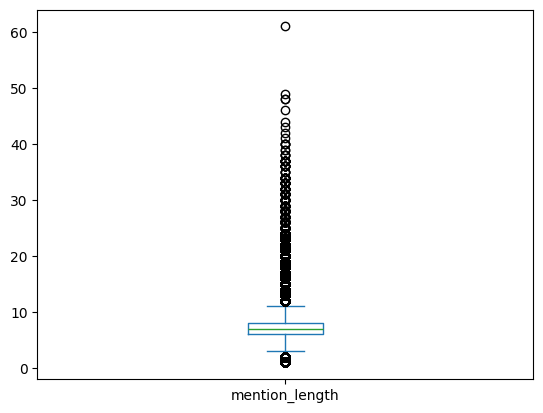

In [38]:
# 95% of the entity mentions are at most 12 characters long
# the remaining 5% are outliers, with a length of up to 61 characters
df.mention_length.plot.box()

In [42]:
# longer mentions are not that many...
df[df.mention_length > 30].shape

(122, 6)

In [43]:
# on the contrary, the short ones (up to 2 chars) are quite a few
df[df.mention_length <= 2].shape

(9740, 6)

In [39]:
# Let's take a look at some of the longest mentions
df[df.mention_length > 30].sample(50)

,document_id,segment_text,entity_type,mention,mention_length,mention_normalised
279189,bpt6k15110748.tar.gz.tei_segmented_ner,"TOMBEAU De feu Messire Français de Bridieu, Ab...",persName,Monseigneur l'Archèvesque de Reims,34,monseigneur l'archèvesque de reims
133945,bpt6k1525193g.tar.gz.tei_segmented_ner,"Notre cher, et bien amé DENIS THIERY, Marchand...",persName,Jean Baptiste Poclin de Molière,31,jean baptiste poclin de molière
25755,bpt6k1090060x.tar.gz.tei_segmented_ner,"À MONSEIGEUR, MONSEIGNEURMESIRE SÉBASTIEN DE P...",persName,MONSEIGNEURMESIRE SÉBASTIEN DE POUROY,37,monseigneurmesire sébastien de pouroy
268710,bpt6k1090186h.tar.gz.tei_segmented_ner,À MONSEIGNEUR LE DU dernière DE AVLAVLETEEE 96,persName,MONSEIGNEUR LE DU dernière DE AVLAVLETEEE,41,monseigneur le du dernière de avlavleteee
188755,bpt6k6509381p.tar.gz.tei_segmented_ner,OUR MONSEIGNEUR LE DUC DE MONTMORENCY,persName,MONSEIGNEUR LE DUC DE MONTMORENCY,33,monseigneur le duc de montmorency
256220,bpt6k1280564h.tar.gz.tei_segmented_ner,Il est permis à Jean-Baptiste Pocquelin de Mol...,persName,Jean-Baptiste Pocquelin de Molière,34,jean-baptiste pocquelin de molière
208966,bpt6k1280537m.tar.gz.tei_segmented_ner,moi aimer une jeune et belune pertonneqrurhomu...,persName,Monsieur le Baron de Sotenville,31,monsieur le baron de sotenville
79366,bpt6k8569793.tar.gz.tei_segmented_ner,Quatrain de Monsieur Brunesaux Abé de Rangual,persName,Monsieur Brunesaux Abé de Rangual,33,monsieur brunesaux abé de rangual
248940,bpt6k5783830q.tar.gz.tei_segmented_ner,Il est permis à Jean Baptiste Poquelin de Moli...,persName,Jean Baptiste Poquelin de Molière,33,jean baptiste poquelin de molière
15556,bpt6k57724367.tar.gz.tei_segmented_ner,"Hola ho, Toucarali Dora Roc Lurducacil Dom Zap...",persName,Toucarali Dora Roc Lurducacil Dom Zapata,40,toucarali dora roc lurducacil dom zapata


In [45]:
# let's see the short entity mentions in context
for idx, row in df[df.mention_length <= 2].sample(10).iterrows():
    template = f"idx: {idx}, mention: {row.mention}, segment_text: {row.segment_text}"
    print(template)

idx: 5145, mention: D, segment_text: Mais enfin quel qu'il soit, souvenez-vous de grâce Qu il faut que mon affront par D
idx: 15770, mention: M, segment_text: eB51 ÉiUn denn dis M
idx: 187800, mention: M, segment_text: 
M

idx: 94618, mention: C, segment_text: En l'état où vous met son crime, et votre ennui, C' est trop pourioous, abradamt, et t'est trop peu pour lui.
idx: 10405, mention: N, segment_text: 
N

idx: 114330, mention: M, segment_text: Voici M
idx: 105058, mention: M, segment_text: 
M

idx: 223007, mention: M, segment_text: 
M

idx: 227695, mention: M, segment_text: 
M

idx: 183930, mention: M, segment_text: 
M



#### Stats on nb. of mentions by document

In [46]:
mentions_by_doc = df.pivot_table(index='document_id', columns='entity_type', values='mention', aggfunc='count', fill_value=0)

In [48]:
mentions_by_doc['total_mentions'] = mentions_by_doc.sum(axis=1)

In [142]:
mentions_by_doc.persName.describe()

count     594.000000
mean      463.067340
std       403.421616
min        78.000000
25%       254.000000
50%       366.500000
75%       529.750000
max      3933.000000
Name: persName, dtype: float64

In [51]:
mentions_by_doc.persName.quantile(0.95)

1119.0500000000002

In [145]:
mentions_by_doc.placeName.describe()

count    594.000000
mean      28.853535
std       37.635786
min        0.000000
25%        9.000000
50%       17.000000
75%       32.000000
max      405.000000
Name: placeName, dtype: float64

In [52]:
mentions_by_doc.placeName.quantile(0.95)

93.0

<Axes: >

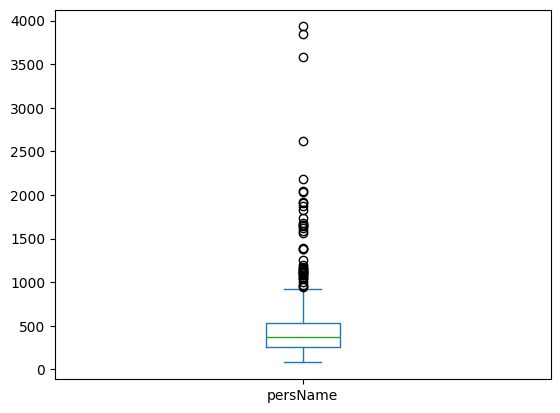

In [143]:
mentions_by_doc.persName.plot.box()

<Axes: >

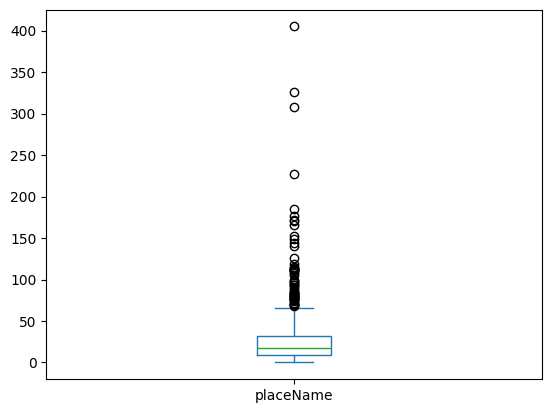

In [144]:
mentions_by_doc.placeName.plot.box()

In [53]:
mentions_by_doc.placeName.quantile(0.95)

93.0

In [149]:
mentions_by_doc.persName.quantile(0.95)

1119.0500000000002

In [54]:
mentions_by_doc[mentions_by_doc.persName > mentions_by_doc.persName.quantile(0.95)].index.to_list()

['bpt6k1090035v.tar.gz.tei_segmented_ner',
 'bpt6k1090087k.tar.gz.tei_segmented_ner',
 'bpt6k1090269b.tar.gz.tei_segmented_ner',
 'bpt6k10902737.tar.gz.tei_segmented_ner',
 'bpt6k1090274n.tar.gz.tei_segmented_ner',
 'bpt6k1090279q.tar.gz.tei_segmented_ner',
 'bpt6k1090295t.tar.gz.tei_segmented_ner',
 'bpt6k1090297n.tar.gz.tei_segmented_ner',
 'bpt6k1090305r.tar.gz.tei_segmented_ner',
 'bpt6k12801963.tar.gz.tei_segmented_ner',
 'bpt6k12803605.tar.gz.tei_segmented_ner',
 'bpt6k1280396s.tar.gz.tei_segmented_ner',
 'bpt6k12805596.tar.gz.tei_segmented_ner',
 'bpt6k15100368.tar.gz.tei_segmented_ner',
 'bpt6k1525193g.tar.gz.tei_segmented_ner',
 'bpt6k5690275b.tar.gz.tei_segmented_ner',
 'bpt6k5745752g.tar.gz.tei_segmented_ner',
 'bpt6k5754483z.tar.gz.tei_segmented_ner',
 'bpt6k5767243z.tar.gz.tei_segmented_ner',
 'bpt6k6257840h.tar.gz.tei_segmented_ner',
 'bpt6k62757707.tar.gz.tei_segmented_ner',
 'bpt6k63635719.tar.gz.tei_segmented_ner',
 'bpt6k6509381p.tar.gz.tei_segmented_ner',
 'bpt6k6586

In [58]:
mentions_df = df

In [70]:
pd.set_option('display.min_rows', 500)  # <-add this!
pd.set_option('display.max_rows', 500)
doc_to_inspect = 'bpt6k1090035v.tar.gz.tei_segmented_ner'

In [71]:
display(mentions_df[mentions_df.document_id == doc_to_inspect])

,document_id,segment_text,entity_type,mention,mention_length,mention_normalised
102240,bpt6k1090035v.tar.gz.tei_segmented_ner,"TROTEREL Escuyer, sieur D'Auvre",persName,D'Auvre,7,d'auvre
102241,bpt6k1090035v.tar.gz.tei_segmented_ner,"À MONSIEUR D'AVÉ, SUR SON ORÉADE DU Mont Olympe",persName,D'AVÉ,5,d'avé
102242,bpt6k1090035v.tar.gz.tei_segmented_ner,"À MONSIEUR D'AVÉ, SUR SON ORÉADE DU Mont Olympe",placeName,Mont Olympe,11,mont olympe
102243,bpt6k1090035v.tar.gz.tei_segmented_ner,"09 Aues, Madame ne crois point qu'Amour en tes...",placeName,Monts de Pinde,14,monts de pinde
102244,bpt6k1090035v.tar.gz.tei_segmented_ner,"09 Aues, Madame ne crois point qu'Amour en tes...",placeName,Parnasse,8,parnasse
102245,bpt6k1090035v.tar.gz.tei_segmented_ner,Mais ie bien plustost que la troupe des Dieux ...,persName,Oreade Olympe,13,oreade olympe
102246,bpt6k1090035v.tar.gz.tei_segmented_ner,"Vous décrivez si bien cet amoureux Olympe, Où ...",persName,Olympe,6,olympe
102247,bpt6k1090035v.tar.gz.tei_segmented_ner,"Vous décrivez si bien cet amoureux Olympe, Où ...",persName,Mu,2,mu
102248,bpt6k1090035v.tar.gz.tei_segmented_ner,Car Olympe est le mont où Phebus tient sa Cour...,persName,Phebus,6,phebus
102249,bpt6k1090035v.tar.gz.tei_segmented_ner,Car Olympe est le mont où Phebus tient sa Cour...,placeName,Olympe,6,olympe


In [73]:
mentions_df[mentions_df.document_id == doc_to_inspect].mention_normalised.value_counts()

mention_normalised
aron                             128
cléan                            123
cléanthe                          98
pyrandre                          91
aronthe                           86
l'oreade                          75
phil                              65
oreade                            49
philodice                         45
philod                            42
l'oréade                          24
seigneur                          21
pirandre                          20
morosophe                         19
mont olympe                       18
venus                             12
calisthène                        10
diane                              9
cleanthe                           9
démonace                           9
simias                             8
jupiter                            7
clea                               7
dioclide                           6
d'aronthe                          6
bergère                            5
pyride             

In [77]:
docs_df.head()

,text,path,word_count
ark_id,,,
bpt6k5628858f,ADONIS . *. 2 TRAGÉDIE FRANÇOISE DE ABRIEL LE...,TheatreLFSV2-downloaded/NER/bpt6k5628858f.tar....,8163
btv1b8610790n,Extrait du Privilège du Roi. Ar Grâce et Privi...,TheatreLFSV2-downloaded/NER/btv1b8610790n.tar....,16256
bpt6k10900405,TREFACL. Ly a peu d'Histoires aussi connues qu...,TheatreLFSV2-downloaded/NER/bpt6k10900405.tar....,12525
bpt6k63635719,LES CHASTES ET LOYALES AMOURS DE IEIEIECDAV. E...,TheatreLFSV2-downloaded/NER/bpt6k63635719.tar....,90847
bpt6k1280315b,"À PARIS, Chez FRANOIS TARGA, AUGUSTI et OURBE ...",TheatreLFSV2-downloaded/NER/bpt6k1280315b.tar....,19512


In [78]:
docs_df[docs_df.index == doc_to_inspect.split('.')[0]]

,text,path,word_count
ark_id,,,
bpt6k1090035v,"Le tout enrichi de plusieurs belles remarques,...",TheatreLFSV2-downloaded/NER/bpt6k1090035v.tar....,78880
